In [1]:
import torch
import os
import numpy as np
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
import import_ipynb
import gibbs_sampler_poise
import kl_divergence_calculator
import data_preprocessing
from torchvision.utils import save_image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.nn import functional as F  #for the activation function
from torchviz import make_dot
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import torchvision
import umap
import random
import shutil

importing Jupyter notebook from gibbs_sampler_poise.ipynb
importing Jupyter notebook from kl_divergence_calculator.ipynb
importing Jupyter notebook from data_preprocessing.ipynb


In [2]:
# learning parameters
latent_dim1 = 32
latent_dim2 = 16
batch_size = 10
dim_MNIST   = 784
lr = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tx = transforms.ToTensor()
PATH = "/home/achint/Practice_code/Synthetic_dataset/POISE_VAE_even_odd_MNIST/untitled.txt"
MNIST_TRAINING_PATH = "/home/achint/Practice_code/VAE/MNIST/MNIST/processed/training.pt"
MNIST_TEST_PATH     = "/home/achint/Practice_code/VAE/MNIST/MNIST/processed/test.pt"
SUMMARY_WRITER_PATH = "/home/achint/Practice_code/logs"
CROSS_RECONSTRUCTION_PATH = "/home/achint/Practice_code/Synthetic_dataset/POISE_VAE_even_odd_MNIST/reconstructions_experiment/cross_generation/"
JOINT_RECONSTRUCTION_PATH = "/home/achint/Practice_code/Synthetic_dataset/POISE_VAE_even_odd_MNIST/reconstructions_experiment/joint_generation/"

In [14]:
## Importing MNIST and MNIST datasets
joint_dataset_train = data_preprocessing.JointDataset(mnist_pt_path_1 = MNIST_TRAINING_PATH,
                                                      mnist_pt_path_2 = MNIST_TRAINING_PATH)
joint_dataset_test = data_preprocessing.JointDataset(mnist_pt_path_1 = MNIST_TEST_PATH,
                                                     mnist_pt_path_2 = MNIST_TEST_PATH)

joint_dataset_train_loader = DataLoader(
    joint_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)
joint_dataset_test_loader = DataLoader(
    joint_dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

In [15]:

class VAE(nn.Module):
    def __init__(self,latent_dim1, latent_dim2, batch_size,use_mse_loss=True):
        super(VAE,self).__init__()
        self.latent_dim1 = latent_dim1
        self.latent_dim2 = latent_dim2
        self.batch_size = batch_size
        self.use_mse_loss = use_mse_loss
        self.gibbs                   = gibbs_sampler_poise.gibbs_sampler(self.latent_dim1, self.latent_dim2, self.batch_size)  
        self.kl_div                  = kl_divergence_calculator.kl_divergence(self.latent_dim1, self.latent_dim2, self.batch_size)
        ## Encoder set1(MNIST)
        self.set1_enc1 = nn.Linear(in_features = dim_MNIST,out_features = 512)
        self.set1_enc2 = nn.Linear(in_features = 512,out_features = 128)
        self.set1_enc3 = nn.Linear(in_features = 128,out_features = 2*latent_dim1)
        ## Encoder set2(MNIST)
        self.set2_enc1 = nn.Linear(in_features = dim_MNIST,out_features = 512)
        self.set2_enc2 = nn.Linear(in_features = 512,out_features = 128)
        self.set2_enc3 = nn.Linear(in_features = 128,out_features = 2*latent_dim2) 
        ## Decoder set1(MNIST)
        self.set1_dec1 = nn.Linear(in_features = latent_dim1,out_features = 128)
        self.set1_dec2 = nn.Linear(in_features = 128,out_features = 512)
        self.set1_dec3 = nn.Linear(in_features = 512,out_features = dim_MNIST)
        ## Decoder set2(MNIST)
        self.set2_dec1 = nn.Linear(in_features = latent_dim2,out_features = 128)
        self.set2_dec2 = nn.Linear(in_features = 128,out_features = 512)
        self.set2_dec3 = nn.Linear(in_features = 512,out_features = dim_MNIST)
        self.register_parameter(name='g11', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.register_parameter(name='g22', param = nn.Parameter(torch.randn(latent_dim1,latent_dim2)))
        self.flag_initialize= 1
#         self.g11=torch.zeros(latent_dim1,latent_dim2).to(device)
#         self.g22=torch.zeros(latent_dim1,latent_dim2).to(device)        
        self.g12= torch.zeros(latent_dim1,latent_dim2).to(device)
    def forward(self,x1,x2,cross_generation,joint_generation):
        data1    = x1 #MNIST
        data2    = x2 #MNIST

        # Modality 1 (MNIST)
        x1       = F.relu(self.set1_enc1(x1))
        x1       = F.relu(self.set1_enc2(x1))  
        x1       = self.set1_enc3(x1).view(-1,2,latent_dim1)  # ->[128,2,32]
        mu1      = x1[:,0,:] # ->[128,32]
        log_var1 = x1[:,1,:] # ->[128,32]
        var1     = -torch.exp(log_var1)           #lambdap_2<0
        # Modality 2 (MNIST)
        x2       = F.relu(self.set2_enc1(x2))
        x2       = F.relu(self.set2_enc2(x2))  
        x2       = self.set2_enc3(x2).view(-1,2,latent_dim2)  # ->[128,2,32]
        mu2      = x2[:,0,:] # ->[128,32]
        log_var2 = x2[:,1,:] # ->[128,32]
        var2     = -torch.exp(log_var2)           #lambdap_2<0     
        g22      = -torch.exp(self.g22) 
        if cross_generation:
            mu2   = torch.zeros_like(mu2)
            var2   = torch.zeros_like(var2)
        elif joint_generation:
            mu1   = torch.zeros_like(mu1)
            var1  = torch.zeros_like(var1)
            mu2   = torch.zeros_like(mu2)
            var2  = torch.zeros_like(var2)

# Initializing gibbs sample        
        if self.flag_initialize==1:
            z1_prior,z2_prior = self.gibbs.gibbs_sample(self.flag_initialize,
                                                        torch.zeros_like(mu1),
                                                        torch.zeros_like(mu2),
                                                        self.g11,
                                                        g22,
                                                        torch.zeros_like(mu1),
                                                        torch.zeros_like(var1),
                                                        torch.zeros_like(mu2),
                                                        torch.zeros_like(var2),
                                                        n_iterations=5000)
            z1_posterior,z2_posterior = self.gibbs.gibbs_sample(self.flag_initialize,
                                                                torch.zeros_like(mu1),
                                                                torch.zeros_like(mu2),
                                                                self.g11,
                                                                g22,
                                                                mu1, 
                                                                var1,
                                                                mu2,
                                                                var2,
                                                                n_iterations=5000)
            self.z1_prior        = z1_prior
            self.z2_prior        = z2_prior
            self.z1_posterior    = z1_posterior
            self.z2_posterior    = z2_posterior
            self.flag_initialize = 0
        z1_prior     = self.z1_prior.detach()
        z2_prior     = self.z2_prior.detach()
        z1_posterior = self.z1_posterior.detach()
        z2_posterior = self.z2_posterior.detach()
        self.z1_gibbs_prior,self.z2_gibbs_prior         = self.gibbs.gibbs_sample(self.flag_initialize,
                                                                                  z1_prior,
                                                                                  z2_prior,
                                                                                  self.g11,
                                                                                  g22,
                                                                                  torch.zeros_like(mu1),
                                                                                  torch.zeros_like(var1),
                                                                                  torch.zeros_like(mu2),
                                                                                  torch.zeros_like(var2),
                                                                                  n_iterations=500)
        self.z1_gibbs_posterior,self.z2_gibbs_posterior = self.gibbs.gibbs_sample(self.flag_initialize,
                                                                                  z1_posterior,
                                                                                  z2_posterior,
                                                                                  self.g11,
                                                                                  g22,
                                                                                  mu1,
                                                                                  var1,
                                                                                  mu2,
                                                                                  var2,
                                                                                  n_iterations=500)
        self.z1_posterior = self.z1_gibbs_posterior.detach()
        self.z2_posterior = self.z2_gibbs_posterior.detach()
        self.z1_prior = self.z1_gibbs_prior.detach()
        self.z2_prior = self.z2_gibbs_prior.detach()
        G1 = torch.cat((self.g11,self.g12),0)
        G2 = torch.cat((self.g12,g22),0)
        G  = torch.cat((G1,G2),1)

        # decoding for MNIST1
        x1 = F.relu(self.set1_dec1(self.z1_gibbs_posterior))
        x1 = self.set1_dec2(x1)
        # decoding for MNIST2
        x2 = F.relu(self.set2_dec1(self.z2_gibbs_posterior))
        x2 = self.set2_dec2(x2)
        
        
        if self.use_mse_loss:
            reconstruction1 = self.set1_dec3(x1)
            reconstruction2 = self.set2_dec3(x2)
        else:
            reconstruction1 = torch.sigmoid(self.set1_dec3(x1))
            reconstruction2 = torch.sigmoid(self.set2_dec3(x2))
        
        
        # calculating loss
        part_fun0,part_fun1,part_fun2 = self.kl_div.calc(G,self.z1_gibbs_posterior,self.z2_gibbs_posterior,self.z1_gibbs_prior,self.z2_gibbs_prior,mu1,var1,mu2,var2)
        if self.use_mse_loss:
            mse_loss = nn.MSELoss(reduction='sum')
            MSE1 = mse_loss(reconstruction1, data1)
            MSE2 = mse_loss(reconstruction2, data2)
        else:
            bce_loss = nn.BCELoss(reduction='sum')
            MSE1 = bce_loss(reconstruction1, data1)
            MSE2 = bce_loss(reconstruction2, data2)

        KLD  = part_fun0+part_fun1+part_fun2
        if self.flag_initialize==0:
#             make_dot(g22,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("g22", format="png")
#             make_dot(self.g11,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("g11", format="png")

#             make_dot(part_fun1,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("part_fun1", format="png")
#             make_dot(part_fun2,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("part_fun2", format="png")
#             make_dot(MSE1,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("MSE1", format="png")
#             make_dot(MSE2,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("MSE2", format="png")
#             make_dot(self.z1_gibbs_prior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z1_prior", format="png")
#             make_dot(self.z2_gibbs_prior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z2_prior", format="png")
#             make_dot(self.z1_gibbs_posterior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z1_posterior", format="png")
#             make_dot(self.z2_gibbs_posterior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z2_posterior", format="png")
#             make_dot(self.z2_posterior,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("z2_posterior_val", format="png")
#             make_dot(mu1,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("mu1", format="png")
#             make_dot(var1,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("var1", format="png")
#             make_dot(mu2,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("mu2", format="png")
#             make_dot(var2,params=dict(model.named_parameters()),show_attrs=True, show_saved=True).render("var2", format="png")

            self.flag_initialize=5
        
        loss = MSE1+MSE2+KLD

        return self.z1_posterior,self.z2_posterior,reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss, MSE1, MSE2, KLD

In [16]:
model = VAE(latent_dim1, latent_dim2, batch_size,use_mse_loss=True).to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)
for name, para in model.named_parameters():
    print(name)

g11
g22
set1_enc1.weight
set1_enc1.bias
set1_enc2.weight
set1_enc2.bias
set1_enc3.weight
set1_enc3.bias
set2_enc1.weight
set2_enc1.bias
set2_enc2.weight
set2_enc2.bias
set2_enc3.weight
set2_enc3.bias
set1_dec1.weight
set1_dec1.bias
set1_dec2.weight
set1_dec2.bias
set1_dec3.weight
set1_dec3.bias
set2_dec1.weight
set2_dec1.bias
set2_dec2.weight
set2_dec2.bias
set2_dec3.weight
set2_dec3.bias


In [24]:
def test(model,joint_dataloader,epoch,cross_generation,joint_generation):
    latent_repMNIST_1 = []
    latent_repMNIST_2 = []
    label_mnist_1= []
    label_mnist_2= []
    #model.load_state_dict(torch.load(PATH))
    state = torch.load(PATH)
    model.load_state_dict(state['state_dict'])

    model.eval()
    running_mse1 = 0.0
    running_mse2 = 0.0
    running_kld  = 0.0
    running_loss = 0.0
    with torch.no_grad():
        for i,joint_data in enumerate(joint_dataloader):
            data1   = joint_data[0]
            data1   = data1.float()
            data2   = joint_data[1]
            data2   = data2.float()
            data1   = data1.to(device)
            data2   = data2.to(device)
            data1   = data1.view(data1.size(0), -1)
            data2   = data2.view(data2.size(0), -1)
            if cross_generation:
                data2   = torch.zeros_like(data2)
            elif joint_generation:
                data1   = torch.zeros_like(data1)
                data2   = torch.zeros_like(data2)
            label1  =joint_data[2]
            label2  =joint_data[3]
            z1_posterior,z2_posterior,reconstruction1,reconstruction2,mu1,var1,mu2,var2,loss, MSE1, MSE2, KLD = model(data1,data2,cross_generation,joint_generation)  
            running_loss += loss.item()
            running_mse1 += MSE1.item()
            running_mse2 += MSE2.item()
            running_kld += KLD.item()
            
            latent_repMNIST_1.append(z1_posterior)
            latent_repMNIST_2.append(z2_posterior)
            label_mnist_1.append(label1)
            label_mnist_2.append(label2)
            
            #save the last batch input and output of every epoch
            if i == int(len(joint_dataloader.dataset)/joint_dataloader.batch_size) - 1:
                num_rows = 8
                both  = torch.cat((data1.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction1.view(batch_size, 1, 28, 28)[:8]))

                bothp = torch.cat((data2.view(batch_size, 1, 28, 28)[:8], 
                                  reconstruction2.view(batch_size, 1, 28, 28)[:8]))
                both_single = torch.cat((both,bothp),0)
#                 save_image(both.cpu(),  os.path.join(CROSS_RECONSTRUCTION_PATH, f"1_outputMNIST_1_{epoch}.png"), nrow=num_rows)
#                 save_image(bothp.cpu(), os.path.join(CROSS_RECONSTRUCTION_PATH, f"2_outputMNIST_2_{epoch}.png"), nrow=num_rows)
                if cross_generation: 
                    save_image(both_single.cpu(), os.path.join(CROSS_RECONSTRUCTION_PATH, f"cross_generation_{epoch}.png"), nrow=num_rows)
                elif joint_generation:
                    save_image(both_single.cpu(), os.path.join(JOINT_RECONSTRUCTION_PATH, f"joint_generation_{epoch}.png"), nrow=num_rows)

    test_loss = running_loss/(len(joint_dataloader.dataset))
    mse1_loss = running_mse1 / (len(joint_dataloader.dataset))
    mse2_loss = running_mse2 / (len(joint_dataloader.dataset))
    kld_loss = running_kld / (len(joint_dataloader.dataset))
    for name, param in model.named_parameters():
        writer.add_histogram(name, param.clone().cpu().data.numpy(), epoch)
    latent_repMNIST_1 = torch.vstack(latent_repMNIST_1).cpu().numpy()
    latent_repMNIST_2 = torch.vstack(latent_repMNIST_2).cpu().numpy()
    label_mnist_1     = torch.hstack(label_mnist_1).cpu().numpy()
    label_mnist_2     = torch.hstack(label_mnist_2).cpu().numpy()
    return test_loss,latent_repMNIST_1,latent_repMNIST_2,label_mnist_1,label_mnist_2

In [25]:
test_loss = []
epochs = 2
writer=SummaryWriter(SUMMARY_WRITER_PATH)
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    test_epoch_loss,latent_repMNIST_1,latent_repMNIST_2,label_mnist_1,label_mnist_2 = test(model,
                                                                                           joint_dataset_test_loader,
                                                                                           epoch,
                                                                                           cross_generation=False,
                                                                                           joint_generation=True)
    test_loss.append(test_epoch_loss)     
    print(f"Test Loss: {test_epoch_loss:.4f}")

Epoch 1 of 2
Test Loss: 134.6736
Epoch 2 of 2
Test Loss: 135.5462


In [60]:
for name,params in model.named_parameters():
    x= params
    break
x.size()    
#model.named_parameters()

torch.Size([32, 16])

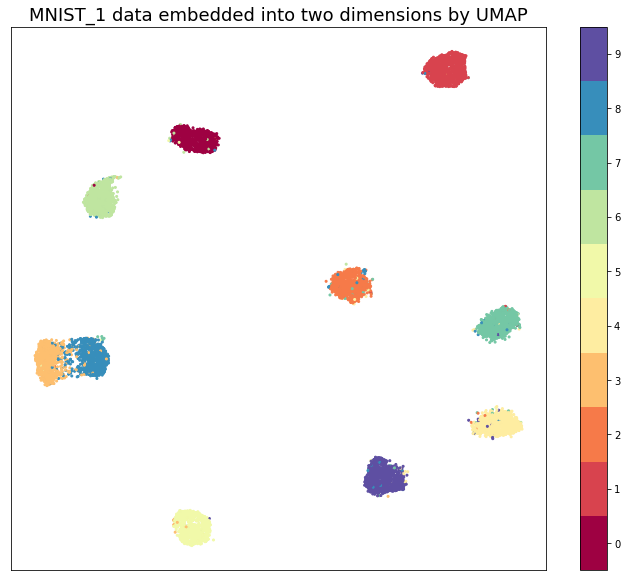

In [12]:
reducer   = umap.UMAP()
data      = latent_repMNIST_1   ## stores posterior samples (10000x32 datapoints)
color     = label_mnist_1       ## stores corresponding labels (10000, labels)
embedding = reducer.fit_transform(data)
fig, ax   = plt.subplots(1,figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1],c=color, cmap="Spectral", s=4)
plt.setp(ax, xticks=[], yticks=[])
cbar      = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(np.arange(10))
plt.title("MNIST_1 data embedded into two dimensions by UMAP", fontsize=18)
ax.set_facecolor('white')
plt.show()    

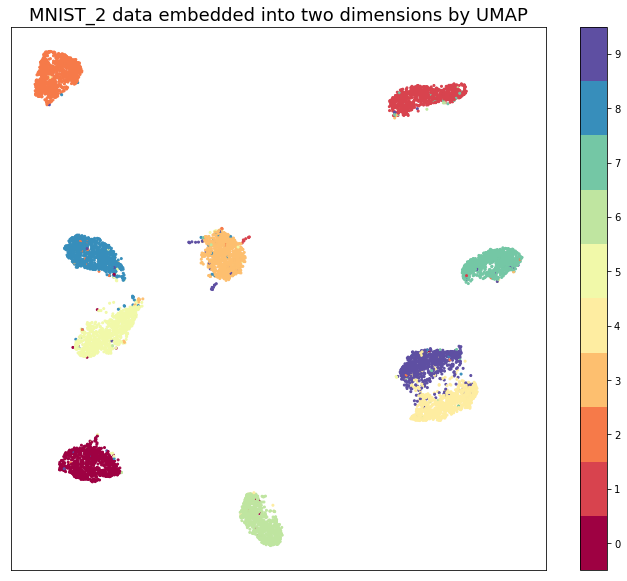

In [13]:
reducer   = umap.UMAP()
data      = latent_repMNIST_2   ## stores posterior samples (10000x32 datapoints)
color     = label_mnist_2       ## stores corresponding labels (10000, labels)
embedding = reducer.fit_transform(data)
fig, ax   = plt.subplots(1,figsize=(12, 10))
plt.scatter(embedding[:, 0], embedding[:, 1],c=color, cmap="Spectral", s=4)
plt.setp(ax, xticks=[], yticks=[])
cbar      = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(np.arange(10))
plt.title("MNIST_2 data embedded into two dimensions by UMAP", fontsize=18)
ax.set_facecolor('white')
plt.show()    